# GAN Image Synthesis

## Problem Statement

Generative Adversarial Networks (GANs) have revolutionized the field of artificial intelligence by enabling the generation of highly realistic images. In this Kaggle competition, GANs: Getting Started, participants explore how GANs can be used to generate images that closely resemble real-world examples. The competition provides a dataset of images and challenges participants to train a GAN to synthesize realistic outputs. The goal of this notebook is to develop and train a GAN model to generate high-quality images based on the given dataset.

https://www.kaggle.com/competitions/gan-getting-started/overview

### Dataset Overview

The dataset provided for the competition consists of images structured into four directories, containing both real photos and Monet paintings. The goal is to train a model to apply Monet's painting style to real photos using GANs.

#### Dataset Structure:

- **monet_jpg**: 300 Monet paintings in **JPEG** format (256x256 pixels).
- **monet_tfrec**: 300 Monet paintings in **TFRecord** format (256x256 pixels).
- **photo_jpg**: 7,028 real-world photos in **JPEG** format (256x256 pixels).
- **photo_tfrec**: 7,028 real-world photos in **TFRecord** format (256x256 pixels).

#### Key Details:

- **Image Size**: All images are **256x256 pixels**.
- **Color Format**: Images are in **RGB format (3 channels)**.
- **File Formats**: Both **JPEG** and **TFRecord** formats are available.

#### Task Objective:

Participants must generate Monet-style images from real-world photos and submit them in a ZIP file containing **7,000–10,000 transformed images** of size **256x256**.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import shutil
import os

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.AUTOTUNE

# Exploratory Data Analysis (EDA)

#### What I Did

1. **Data Loading & Visualization** - I loaded a subset of Monet paintings and real photos from their respective TFRecord datasets. I then visualized a few images from each set side by side to observe any stylistic differences, which there were many even to an untrained eye.

2. **Pixel Intensity Distribution** - I computed per-channel histograms (Red, Green, Blue) across a sample of images from both the Monet and photo datasets. This allowed me to see how frequently certain intensity values occur within each channel.

#### What I Observed

1. **Sample Images**

   - **Monet Paintings**: These images show more impressionistic color application, often with a more uniform range of colors.
   - **Real Photos**: These photos display more natural lighting conditions, resulting in a wider variety of brightness levels, shadow details and more stark colors.

2. **Pixel Intensity Distributions**

   - **Monet Paintings** - The distributions are fairly smooth, with peaks in the mid-range intensities. This suggests a style that favors moderate brightness and softer transitions between light and dark areas.
   - **Real Photos** - More pronounced spikes at both darker and brighter intensities which makes sense due to the broader variation in natural lighting and shadows present in real photography.

### Data Preprocessing

Due to the nature of the data and this project there is minimal cleaning or preprocessing that needs to be done other than verifying any corrupted or duplicate files which Kaggle has already done.


Monet_tfrec TFRecord Files: 5
Photo_tfrec TFRecord Files: 20


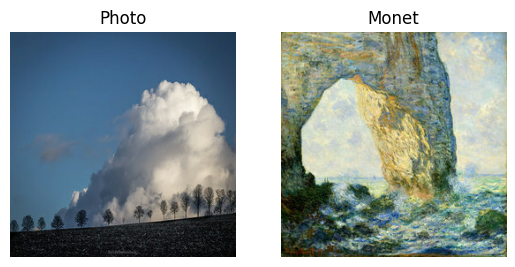

In [29]:
IMAGE_SIZE = (256, 256)


def get_tfrec_files(folder):
    """Get TFRecord files from a specified folder in the data directory."""
    files = tf.io.gfile.glob(os.path.join("data", folder, "*.tfrec"))
    print(f"{folder.capitalize()} TFRecord Files: {len(files)}")
    return files


def process_image(image_bytes):
    """Decode and preprocess an image from raw bytes."""
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return tf.reshape(image, [*IMAGE_SIZE, 3])


def parse_record(record):
    """Parse a single TFRecord example."""
    features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(record, features)
    return process_image(parsed["image"])


def build_dataset(files, batch_size=1):
    """Create a batched dataset from a list of TFRecord files."""
    ds = tf.data.TFRecordDataset(files)
    ds = ds.map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size)


monet_files = get_tfrec_files("monet_tfrec")
photo_files = get_tfrec_files("photo_tfrec")

monet_ds = build_dataset(monet_files)
photo_ds = build_dataset(photo_files)

monet_sample = next(iter(monet_ds))[0]
photo_sample = next(iter(photo_ds))[0]

plt.subplot(121)
plt.title("Photo")
plt.axis("off")
plt.imshow(photo_sample * 0.5 + 0.5)

plt.subplot(122)
plt.title("Monet")
plt.axis("off")
plt.imshow(monet_sample * 0.5 + 0.5)
plt.show()

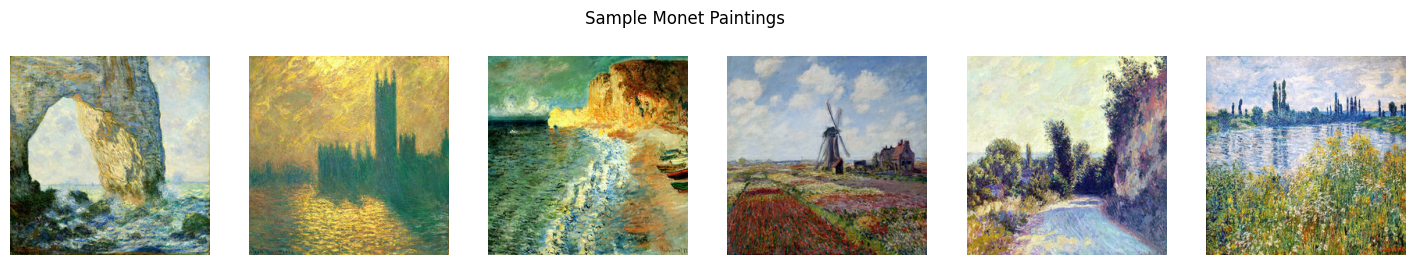

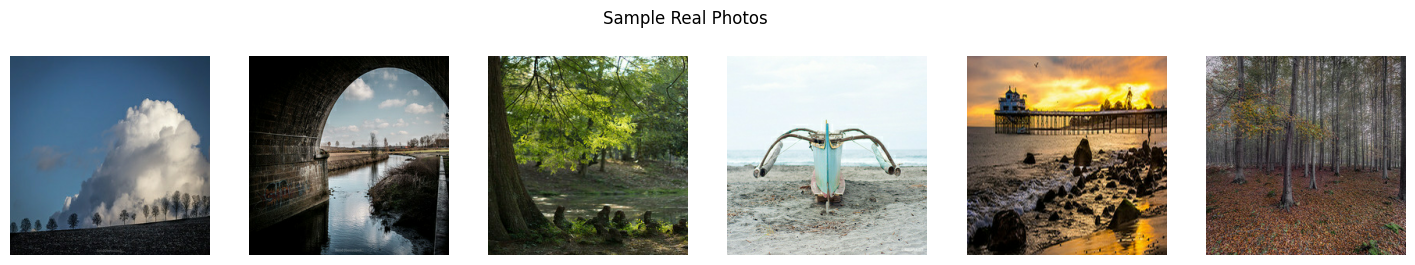

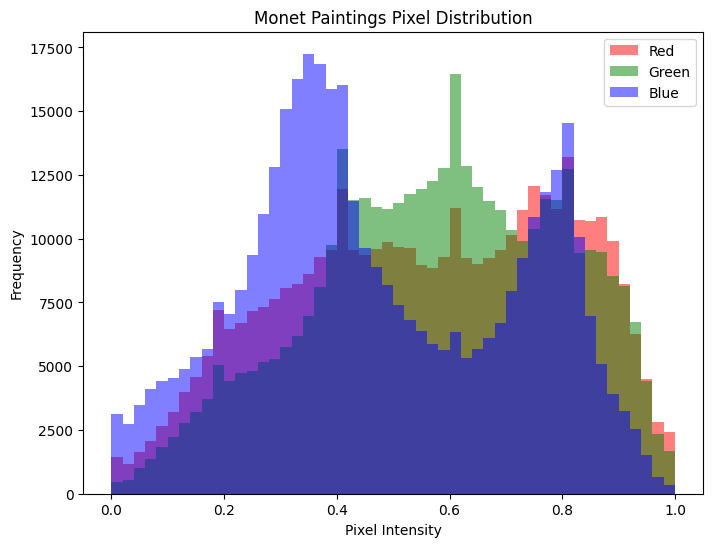

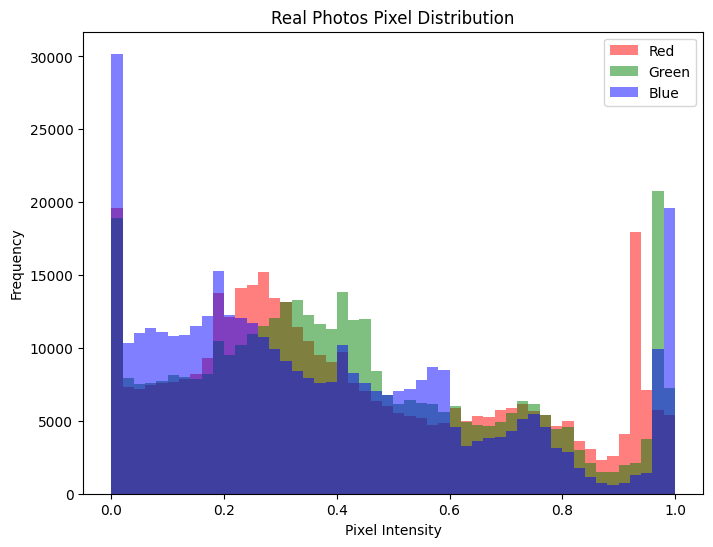

In [30]:
# Function to get a batch of images from a dataset
def get_sample_images(dataset, num_images=9):
    images = []
    for image in dataset.take(num_images):
        images.append(image[0].numpy())
    return np.array(images)


# Function to plot a grid of images
def plot_image_grid(images, title, grid_shape=(1, 6)):
    fig, axes = plt.subplots(
        grid_shape[0], grid_shape[1], figsize=(grid_shape[1] * 3, grid_shape[0] * 3)
    )
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < images.shape[0]:
            # Convert pixel range from [-1,1] to [0,1] for display
            ax.imshow(images[i] * 0.5 + 0.5)
        ax.axis("off")
    plt.show()


# Function to plot per-channel histograms
def plot_channel_histograms(images, title):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    channels = ["Red", "Green", "Blue"]
    colors = ["r", "g", "b"]

    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        channel_data = images[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.5, color=color, label=channels[i])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# Function to compute and print mean and standard deviation
def compute_stats(images):
    # Convert images from [-1,1] to [0,1]
    images = images * 0.5 + 0.5
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    return mean, std


# Get sample images from each dataset
sample_monets = get_sample_images(monet_ds, num_images=6)
sample_photos = get_sample_images(photo_ds, num_images=6)

# Plot image grids
plot_image_grid(sample_monets, "Sample Monet Paintings")
plot_image_grid(sample_photos, "Sample Real Photos")

# Plot channel histograms
plot_channel_histograms(sample_monets, "Monet Paintings Pixel Distribution")
plot_channel_histograms(sample_photos, "Real Photos Pixel Distribution")

# Choosing a GAN Model Architecture

I considered two primary options for transforming real photos into Monet-style images.

First, **DCGAN (Deep Convolutional GAN)** is relatively straightforward to implement and train, and it's best for generating new images from random noise. However, it doesn’t directly address style transfer when there isn’t a paired dataset, making it not the best for my needs.

**CycleGAN** is specifically designed for unpaired image-to-image translation, allowing it to learn how to convert images from one domain (real photos) to another (Monet paintings) without needing exact pairs. Because my dataset lacks one-to-one photo-Monet mappings, I chose **CycleGAN**. Its architecture is specifically designed for this type of work we will be doing in this competition.


## Generator

For my CycleGAN I used a U-Net style generator with the following:

- Downsample Layer: Applies a convolution with stride 2 to reduce spatial dimensions. It also applies group normalization (mimicking instance normalization) followed by a LeakyReLU activation.

- Upsample Layer: Uses transposed convolution to upsample the feature maps. It performs group normalization, applies dropout if specified, and then a ReLU activation.

- Generator Class: Stacks multiple downsampling layers to encode the input into a compressed representation while storing skip connections. The upsampling layers then decode this representation, merging with corresponding skip connections to retain spatial details. A final transposed convolution with tanh activation produces the output image.

This architecture was chosen because it balances the extraction of high-level features with the preservation of fine-grained details. The downsampling layers efficiently capture global context by reducing spatial dimensions, while the upsampling layers, combined with skip connections, reintroduce detailed information that might be lost during compression. This U-Net style design is effective in tasks like image-to-image translation, where maintaining both overall structure and local details is essential for producing realistic outputs.


In [ ]:
class Downsample(layers.Layer):
    def __init__(self, filters, size, apply_instancenorm=True, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = (
            tf.keras.layers.GroupNormalization(
                gamma_initializer=keras.initializers.RandomNormal(
                    mean=0.0, stddev=0.02
                ),
                groups=-1,
            )
            if apply_instancenorm
            else None
        )
        self.activation = layers.LeakyReLU()

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        if self.norm:
            x = self.norm(x)
        return self.activation(x)


class Upsample(layers.Layer):
    def __init__(self, filters, size, apply_dropout=False, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False,
        )
        self.norm = tf.keras.layers.GroupNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
            groups=-1,
        )
        self.dropout = layers.Dropout(0.5) if apply_dropout else None
        self.activation = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv_transpose(inputs)
        x = self.norm(x)
        if self.dropout:
            x = self.dropout(x, training=training)
        return self.activation(x)


class Generator(keras.Model):
    def __init__(self, output_channels=3, **kwargs):
        super().__init__(**kwargs)
        self.down_stack = [
            Downsample(64, 4, apply_instancenorm=False),
            Downsample(128, 4),
            Downsample(256, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
            Downsample(512, 4),
        ]

        self.up_stack = [
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4, apply_dropout=True),
            Upsample(512, 4),
            Upsample(256, 4),
            Upsample(128, 4),
            Upsample(64, 4),
        ]

        self.last_conv = layers.Conv2DTranspose(
            output_channels,
            4,
            strides=2,
            padding="same",
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation="tanh",
        )
        self.concat = layers.Concatenate()

    def call(self, inputs, training=False):
        x = inputs
        skips = []
        for down in self.down_stack:
            x = down(x, training=training)
            skips.append(x)
        # Remove the bottleneck output and reverse the skip connections
        skips = list(reversed(skips[:-1]))
        for up, skip in zip(self.up_stack, skips):
            x = up(x, training=training)
            x = self.concat([x, skip])
        return self.last_conv(x)

## Discriminator

This discriminator model is designed to differentiate between real and generated images. It begins with three downsampling layers that progressively reduce spatial dimensions while increasing feature depth. After downsampling, zero padding prepares the feature maps for a convolutional layer with a stride of 1. Group normalization and LeakyReLU activation stabilize the feature extraction process. Finally, additional zero padding and a concluding convolution produce a single-channel decision map, which indicates the likelihood of the input being real.

This architecture was chosen because it effectively captures both local and global features needed for accurate discrimination between real and fake images. The layered downsampling builds a hierarchical representation, while the normalization and activation functions ensure stable learning. The final convolutional output guides the GAN training by providing precise feedback on whether the input images are real or not.


In [32]:
class Discriminator(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        initializer = tf.random_normal_initializer(0.0, 0.02)
        gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        self.down1 = Downsample(64, 4, apply_instancenorm=False)
        self.down2 = Downsample(128, 4)
        self.down3 = Downsample(256, 4)
        self.zero_pad1 = layers.ZeroPadding2D()
        self.conv = layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer, use_bias=False
        )
        self.norm1 = layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1)
        self.leaky_relu = layers.LeakyReLU()
        self.zero_pad2 = layers.ZeroPadding2D()
        self.last_conv = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)

    def call(self, inputs, training=False):
        x = self.down1(inputs, training=training)
        x = self.down2(x, training=training)
        x = self.down3(x, training=training)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.norm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last_conv(x)


with strategy.scope():
    monet_generator = Generator()  # transforms photos to Monet-esque paintings
    photo_generator = Generator()  # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator()  # differentiates real vs. generated Monet
    photo_discriminator = Discriminator()  # differentiates real vs. generated photos

# CycleGAN

The `CycleGan` class encapsulates two generators (for translating Monet paintings to photos and vice versa) and two discriminators (to distinguish between real and generated images in each domain). It implements cycle consistency by translating an image to the opposite domain and back again, ensuring that the recovered image remains close to the original. The model computes adversarial losses for the generators, cycle consistency losses, and identity losses to preserve key image features. During each training step, gradients are calculated for both generators and discriminators and then applied via their respective optimizers.


In [33]:
class CycleGan(keras.Model):
    def __init__(
        self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle=10, **kwargs
    ):
        super().__init__(**kwargs)
        self.m_gen = monet_gen
        self.p_gen = photo_gen
        self.m_disc = monet_disc
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        **kwargs
    ):
        super().compile(**kwargs)
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def compute_losses(self, real_monet, real_photo):
        # Generate fake images and their cycles
        fake_monet = self.m_gen(real_photo, training=True)
        cycled_photo = self.p_gen(fake_monet, training=True)
        fake_photo = self.p_gen(real_monet, training=True)
        cycled_monet = self.m_gen(fake_photo, training=True)

        # Identity mappings
        same_monet = self.m_gen(real_monet, training=True)
        same_photo = self.p_gen(real_photo, training=True)

        # Discriminator evaluations
        disc_real_monet = self.m_disc(real_monet, training=True)
        disc_fake_monet = self.m_disc(fake_monet, training=True)
        disc_real_photo = self.p_disc(real_photo, training=True)
        disc_fake_photo = self.p_disc(fake_photo, training=True)

        # Generator losses
        monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
        photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

        cycle_loss = self.cycle_loss_fn(
            real_monet, cycled_monet, self.lambda_cycle
        ) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

        id_loss_monet = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
        id_loss_photo = self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

        total_monet_gen_loss = monet_gen_loss + cycle_loss + id_loss_monet
        total_photo_gen_loss = photo_gen_loss + cycle_loss + id_loss_photo

        # Discriminator losses
        monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
        photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        return {
            "total_monet_gen_loss": total_monet_gen_loss,
            "total_photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
        }

    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            losses = self.compute_losses(real_monet, real_photo)

        # Compute gradients for generators
        m_gen_grads = tape.gradient(
            losses["total_monet_gen_loss"], self.m_gen.trainable_variables
        )
        p_gen_grads = tape.gradient(
            losses["total_photo_gen_loss"], self.p_gen.trainable_variables
        )
        # Compute gradients for discriminators
        m_disc_grads = tape.gradient(
            losses["monet_disc_loss"], self.m_disc.trainable_variables
        )
        p_disc_grads = tape.gradient(
            losses["photo_disc_loss"], self.p_disc.trainable_variables
        )

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(
            zip(m_gen_grads, self.m_gen.trainable_variables)
        )
        self.p_gen_optimizer.apply_gradients(
            zip(p_gen_grads, self.p_gen.trainable_variables)
        )
        self.m_disc_optimizer.apply_gradients(
            zip(m_disc_grads, self.m_disc.trainable_variables)
        )
        self.p_disc_optimizer.apply_gradients(
            zip(p_disc_grads, self.p_disc.trainable_variables)
        )

        return {
            "monet_gen_loss": losses["total_monet_gen_loss"],
            "photo_gen_loss": losses["total_photo_gen_loss"],
            "monet_disc_loss": losses["monet_disc_loss"],
            "photo_disc_loss": losses["photo_disc_loss"],
        }

## Loss Methods

The `CycleGanLosses` class defines methods to compute the various loss components:

- **Discriminator Loss**: Uses binary cross-entropy to penalize misclassification of real and fake images.
- **Generator Loss**: Uses binary cross-entropy to encourage generators to produce outputs classified as real.
- **Cycle Loss**: Calculates the mean absolute error between the original and cycled images, scaled by a lambda factor.
- **Identity Loss**: Computes the mean absolute error when an image is passed through its corresponding generator, promoting color and feature preservation.


In [34]:
class CycleGanLosses:
    @staticmethod
    def discriminator_loss(real, generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        real_loss = bce(tf.ones_like(real), real)
        generated_loss = bce(tf.zeros_like(generated), generated)
        return 0.5 * (real_loss + generated_loss)

    @staticmethod
    def generator_loss(generated):
        bce = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        return bce(tf.ones_like(generated), generated)

    @staticmethod
    def cycle_loss(real_image, cycled_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return lambda_cycle * loss

    @staticmethod
    def identity_loss(real_image, same_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_cycle * 0.5 * loss

## Model Training

### Training Setup with `strategy.scope()`

- **Distribution Strategy**:  
  Wrapping the code in `with strategy.scope():` ensures that all variables (including those in optimizers and the model) are created under the distribution strategy, enabling efficient training on multiple devices.

- **Optimizer Configuration**:  
  Adam optimizers are instantiated with a learning rate of `2e-4` and `beta_1` of `0.5`. These settings are applied consistently across both the generators and discriminators, ensuring stable optimization.

- **Model Instantiation and Compilation**:  
  A CycleGAN model is created using the provided generators and discriminators. It is then compiled with the custom loss functions for generators, discriminators, cycle consistency, and identity mapping. These loss functions drive the adversarial and cycle consistency training objectives.

- **Model Training**:  
  The model is trained on a zipped dataset of Monet and photo images for one epoch (due to training time). This trains the model to learn the mappings between the two domains.


In [35]:
with strategy.scope():
    # Configure optimizers with shared settings
    optimizer_config = {"learning_rate": 2e-4, "beta_1": 0.5}
    monet_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    photo_generator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(**optimizer_config)

    # Instantiate and compile the CycleGAN model using the new loss functions
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,
        p_gen_optimizer=photo_generator_optimizer,
        m_disc_optimizer=monet_discriminator_optimizer,
        p_disc_optimizer=photo_discriminator_optimizer,
        gen_loss_fn=CycleGanLosses.generator_loss,
        disc_loss_fn=CycleGanLosses.discriminator_loss,
        cycle_loss_fn=CycleGanLosses.cycle_loss,
        identity_loss_fn=CycleGanLosses.identity_loss,
    )

cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=1)

300/300 ━━━━━━━━━━━━━━━━━━━━ 760s 2s/step - monet_disc_loss: 0.6437 - monet_gen_loss: 5.2090 - photo_disc_loss: 0.6262 - photo_gen_loss: 5.3922


c:\Users\David\Documents\MSCS\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Visualizations

Generate a random sample selection of the image tranformations from real photos to Monet-style

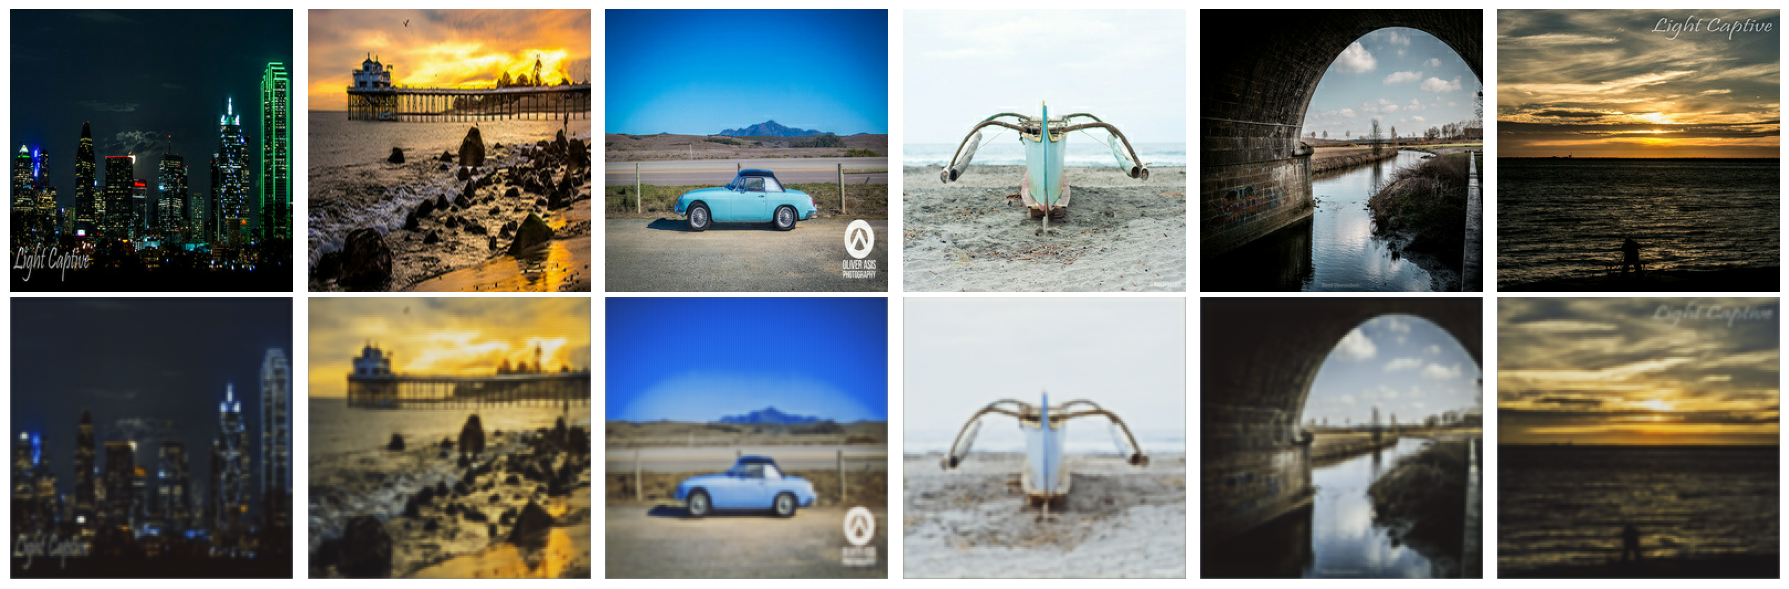

In [36]:
fig, ax = plt.subplots(2, 6, figsize=(18, 6))
for i, img in enumerate(photo_ds.shuffle(10).take(6)):
    original = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    transformed = monet_generator(img, training=False)[0].numpy()
    transformed = (transformed * 127.5 + 127.5).astype(np.uint8)

    ax[0, i].imshow(original)
    ax[0, i].axis("off")
    ax[1, i].imshow(transformed)
    ax[1, i].axis("off")

ax[0, 0].set_ylabel("Input Photos", fontsize=14)
ax[1, 0].set_ylabel("Monet Transformations", fontsize=14)
plt.tight_layout()
plt.show()

# Submission File

Generate a zip file of 7,000-10,000 images for Kaggle submission


In [ ]:
# Create generated images
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image = PIL.Image.fromarray(prediction)
    image.save("images/" + str(i) + ".jpg")
    i += 1

In [40]:
# Make a zip file of the generated images
shutil.make_archive("images", "zip", "images")

'c:\\Users\\David\\Documents\\MSCS\\CSCA-5642-Machine-Learning-III\\kaggle\\images.zip'

# Conclusion

In this project, I built and trained a CycleGAN model to translate between Monet paintings and photos. I implemented U-Net style generators with skip connections and discriminators that progressively extract features using downsampling layers. The model integrates adversarial, cycle consistency, and identity losses to ensure both stylistic transformation and content preservation.

**Lessons Learned**:

- Effective use of skip connections in generators preserves fine details during translation.
- Balancing multiple loss components is crucial for stable training and achieving realistic outputs.
- Proper optimizer configuration and distribution strategies can significantly enhance training efficiency and performance.

**Model Comparisons**:

- **CycleGAN vs. Traditional GANs**: CycleGAN’s cycle consistency loss allows for better image translation over standard GANs.
- **U-Net Generators vs. Simple Encoder-Decoders**: U-Net architectures better maintain spatial information through skip connections ultimately leading to better translations.

**Performance Improvements**:

- Fine-tuning hyperparameters such as learning rates and loss weights can further stabilize and improve training at the increased cost of time.
- Experimenting with deeper architectures, alternative normalization methods, or attention mechanisms may improve the translations.

Overall, I'm satisfied with what I was able to achieve given my current hardware situation. If I had better hardware I would've spent more time training and optimizing different models and parameters to increase my competition score.
